In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [8]:
# Choose the path of the data
X_data_path = "data/X_data_10sec.csv"
y_data_path = "data/y_data_10sec.csv"

In [9]:
# Set the parameters
epochs = 16
seconds = "10sec" # length of each sample, this will be used only to name the files with the results

In [10]:
X_data = np.loadtxt(X_data_path, delimiter=",")
X_data.shape

(3000, 38400)

In [11]:
X_data

array([[  0.28048742,   0.81629074,  -6.23892736, ..., -47.85346985,
        -47.85346985, -38.20292664],
       [ -4.82241011,  -6.21592617, -10.80950356, ..., -46.43103409,
        -46.43103409, -46.43103409],
       [  3.79986668,   5.4657836 ,   5.81849194, ..., -49.15478134,
        -49.15478134, -33.45807266],
       ...,
       [-21.03319359, -24.26096344, -23.05108261, ..., -60.63187408,
        -60.63187408, -42.44838333],
       [ -7.60533714, -11.4787159 , -10.99200726, ..., -61.26615906,
        -61.26615906, -43.74389267],
       [ -8.89348984, -21.42334938, -28.44588852, ..., -59.62312698,
        -59.62312698, -44.60402679]])

In [12]:
y_data = np.loadtxt(y_data_path, dtype=str)
y_data.shape

(3000,)

In [13]:
y_data

array(['blues', 'blues', 'blues', ..., 'rock', 'rock', 'rock'],
      dtype='<U9')

In [14]:
labels = np.unique(y_data)
labels

array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock'], dtype='<U9')

In [15]:
y_data2 = np.zeros((y_data.shape[0], len(labels)))

for i, label in enumerate(labels):
    for j in range(y_data.shape[0]):
        if y_data[j] == label:
            y_data2[j][i] = 1
            
y_data2

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [16]:
X_data2 = X_data.reshape(X_data.shape[0], 128, 300, 1)
X_data2.shape

(3000, 128, 300, 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_data2, y_data2, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2400, 128, 300, 1)
(600, 128, 300, 1)
(2400, 10)
(600, 10)


In [19]:
# def conv_block(x, n_filters=64,filter_size=(7, 128), pool_size=(2, 2),stride=(2, 2)):
#     x = keras.layers.Conv2D(n_filters, filter_size, activation = "relu", strides=(1, 1), padding='same')(x)
#     x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=stride)(x)
#     x = keras.layers.Dropout(0.5)(x)
#     return x
def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = keras.layers.Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = keras.layers.Dropout(0.2)(x)
    return x

In [48]:
nn_input = keras.Input(shape=(128,300,1))
x = conv_block(nn_input, 16,stride=(2,2))
x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
x = conv_block(x, 64, stride=(2,2))
x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
x = conv_block(x, 256,stride=(2,2))

# Step 1: Transpose to move time_steps to the second axis
x = keras.layers.Permute((2, 1, 3))(x)  # Shape: (batch_size, 9, 4, 256)

x = keras.layers.Reshape((9, 4*256), input_shape=(9, 4, 256))(x)
x = keras.layers.GRU(1024, activation="relu", return_sequences=False)(x)
# x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
predictions = keras.layers.Dense(len(labels), activation='softmax')(x)
    
model = keras.Model(inputs=nn_input, outputs=predictions)

In [49]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 300, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 128, 300, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 128, 300, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 64, 150, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64, 150, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 150, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 64, 150, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 32, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 32, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 16, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 16, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 16, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 8, 18, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 8, 18, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 8, 18, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 8, 18, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 4, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 4, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_5 (Permute)             │ (None, 9, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 9, 1024)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 1024)           │     6,297,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 1024)           │             

 Total params: 6,954,890 (26.53 MB)

 Trainable params: 6,954,890 (26.53 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [51]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    patience=10, 
    restore_best_weights=True,
    verbose=1)

history = model.fit(
    X_train,
    y_train,
    epochs=100, 
    batch_size=64,
    validation_split=0.10,
    callbacks = [callback]
)

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.1294 - loss: 2.9590 - val_accuracy: 0.1917 - val_loss: 2.2062
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.2228 - loss: 2.0531 - val_accuracy: 0.2417 - val_loss: 2.0204
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.3711 - loss: 1.7588 - val_accuracy: 0.4375 - val_loss: 1.7074
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.4115 - loss: 1.6018 - val_accuracy: 0.4083 - val_loss: 1.6218
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.4618 - loss: 1.4433 - val_accuracy: 0.4583 - val_loss: 1.5427
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.5006 - loss: 1.3507 - val_accuracy: 0.4958 - val_loss: 1.2535
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.5437 - loss: 1.2340 - val_accuracy: 0.5500 - val_loss: 1.2122
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.5856 - loss: 1.1193 - val_acc

In [54]:
model.save("models/GRU_model_" + seconds + "_final.keras")

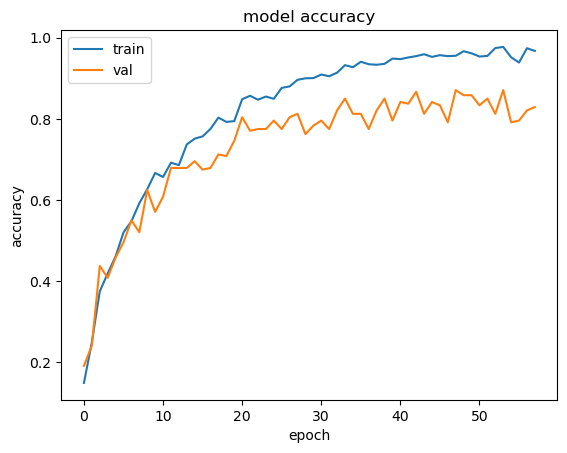

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("images/GRU_accuracy_" + seconds + ".png")
plt.show()

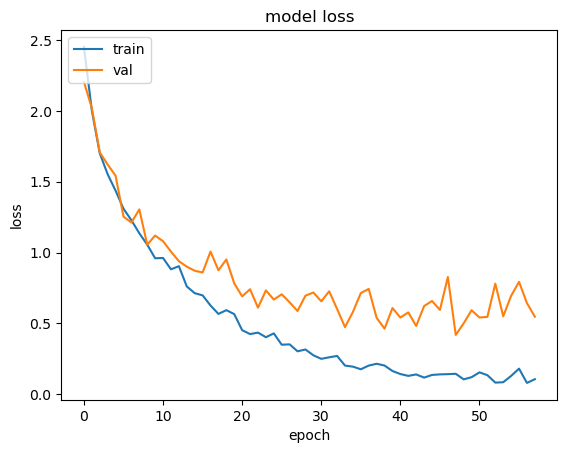

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("images/GRU_loss_" + seconds + ".png")
plt.show()

In [57]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.645 and val_acc = 0.822


In [58]:
y_pred = model.predict(X_test)
print(y_pred.shape)
y_pred

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
(600, 10)


array([[2.0912032e-09, 2.7165166e-11, 8.2116367e-06, ..., 7.3955178e-08,
        2.0734933e-05, 1.5942860e-05],
       [2.2070755e-07, 7.2079059e-10, 1.3991234e-06, ..., 1.3154658e-08,
        2.9644198e-06, 5.5014876e-05],
       [1.3500900e-03, 7.4336684e-04, 3.7243364e-05, ..., 7.3028661e-02,
        6.4121419e-01, 1.7686425e-03],
       ...,
       [7.0742504e-14, 9.8594272e-25, 6.0610619e-20, ..., 1.5525413e-20,
        8.6716042e-14, 4.3370907e-10],
       [2.0687057e-07, 2.1171847e-12, 2.2856732e-10, ..., 1.4504978e-06,
        2.4385902e-04, 1.8146126e-07],
       [4.2897672e-09, 2.0981254e-15, 3.3356412e-12, ..., 8.6342044e-07,
        1.8276990e-06, 3.7329331e-09]], dtype=float32)

In [59]:
y_classes = y_pred.argmax(1)
y_classes[:15]

array([3, 3, 8, 2, 2, 1, 7, 3, 9, 1, 1, 2, 3, 8, 2])

In [60]:
y_test2 = y_test.argmax(1)
y_test2[:15]

array([3, 9, 9, 2, 5, 2, 7, 3, 8, 1, 1, 2, 3, 4, 2])

In [61]:
import sklearn.metrics as mt

accuracy = mt.accuracy_score(y_test2, y_classes)
precision = mt.precision_score(y_test2, y_classes, average = "macro")
recall = mt.recall_score(y_test2, y_classes, average = "macro")
f1_score = mt.f1_score(y_test2, y_classes, average = "macro")
print("accuracy     : " + str(accuracy))
print("precision    : " + str(precision))
print("recall       : " + str(recall))
print("f1-score     : " + str(f1_score))

accuracy     : 0.8216666666666667
precision    : 0.8260403867193589
recall       : 0.8208945068137851
f1-score     : 0.8208145231737347


In [63]:
"""
model_metrics = {
    "epochs" : [48],
    "accuracy" : [accuracy],
    "precision" : [precision],
    "recall" : [recall],
    "f1-score" : [f1_score]
}
df_metrics = pd.DataFrame(model_metrics)
metrics_path = "metrics/GRU_metrics_" + seconds + ".csv"
df_metrics.to_csv(metrics_path, index=False)
"""

In [64]:
metrics_path = "metrics/GRU_metrics_" + seconds + ".csv"
df_metrics = pd.read_csv(metrics_path)
df_metrics

,epochs,accuracy,precision,recall,f1-score
0,48,0.821667,0.82604,0.820895,0.820815


In [66]:
"""
model_metrics = {
    "epochs" : epochs,
    "accuracy" : accuracy,
    "precision" : precision,
    "recall" : recall,
    "f1-score" : f1_score
}
df_metrics = df_metrics.append(model_metrics, ignore_index=True)
df_metrics = df_metrics.sort_values(["epochs"])
df_metrics
"""

'\nmodel_metrics = {\n    "epochs" : epochs,\n    "accuracy" : accuracy,\n    "precision" : precision,\n    "recall" : recall,\n    "f1-score" : f1_score\n}\ndf_metrics = df_metrics.append(model_metrics, ignore_index=True)\ndf_metrics = df_metrics.sort_values(["epochs"])\ndf_metrics\n'

In [65]:
df_metrics.to_csv(metrics_path, index=False)

In [67]:
cm = mt.confusion_matrix(y_test2, y_classes)
print(cm)

[[49  0  4  0  0  0  0  1  2  1]
 [ 1 50  0  1  0  2  0  2  0  1]
 [ 0  2 58  2  0  4  0  0  1  2]
 [ 0  1  2 63  0  0  0  3  0  2]
 [ 0  0  1  0 50  0  0  0  3  1]
 [ 1  1  2  1  0 53  0  1  3  1]
 [ 0  0  0  1  1  0 47  0  0  3]
 [ 0  0  2  1  4  0  0 54  0  3]
 [ 0  0  2  4  3  0  0  3 40  1]
 [ 2  0 11  6  4  2  3  1  1 29]]


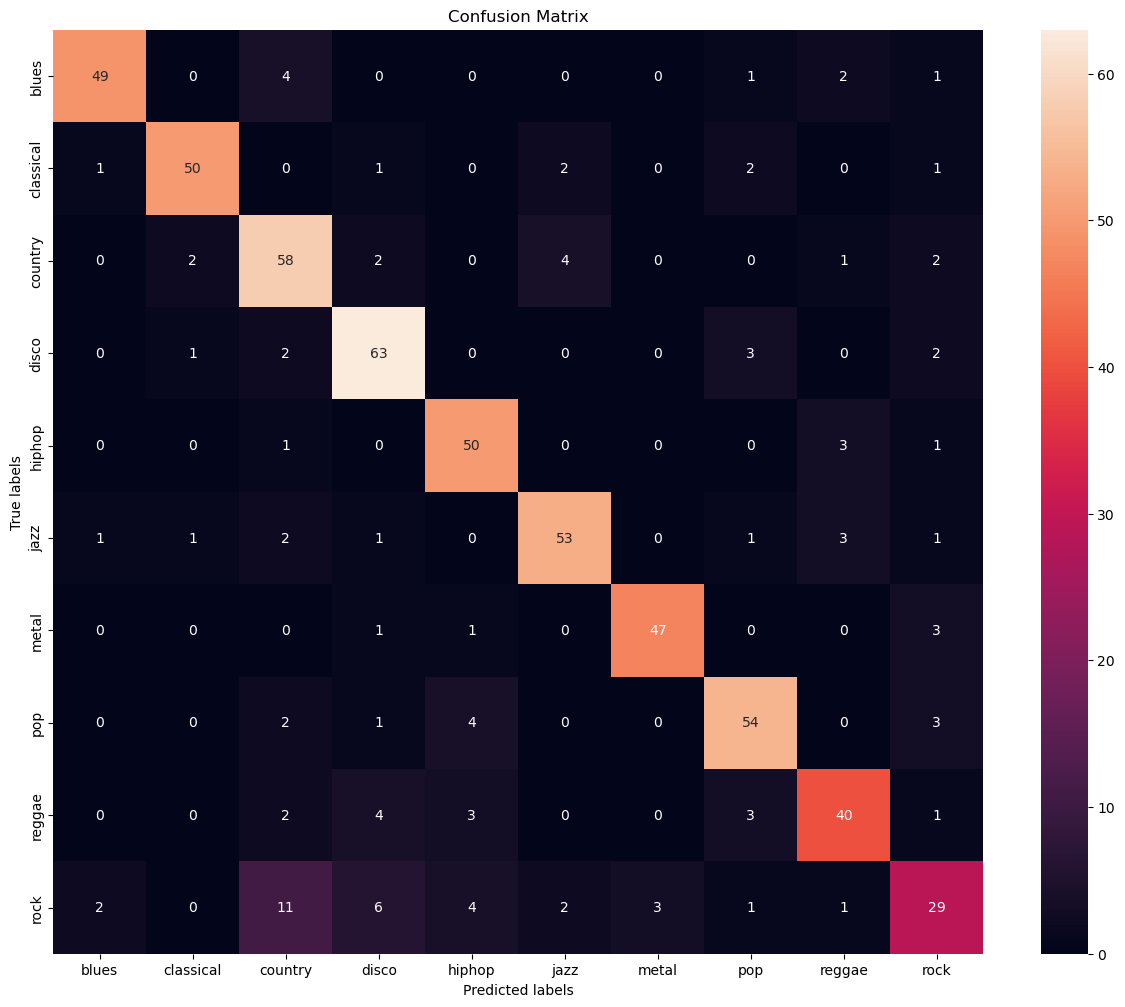

In [69]:
plt.figure(figsize=(15,12))
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  # annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.savefig("images/" + seconds + "/GRU_confusion_matrix_" + str(epochs) + "epochs.png")